# Explore the train/test split

In [7]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/tommylees/github/ml_drought


In [9]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [11]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

In [12]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

In [21]:
# load static data from one of the 
from src.models import load_model

e = load_model(data_dir / 'models' / 'one_month_forecast_VCI_YESstatic' / 'ealstm' / 'model.pt')
dl = e.get_dataloader('train')
static = dl.static
static

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35)
Coordinates:
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
Data variables:
    slt         (lat, lon) float32 ...
    topography  (lat, lon) float32 ...

In [25]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_, static])
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 449)
Coordinates:
  * lat         (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * time        (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2018-12-31
  * lon         (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI         (time, lat, lon) float64 39.36 18.57 19.15 ... 21.15 60.27 22.19
    p84.162     (time, lat, lon) float64 9.101e-06 -2.29e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.006845 -0.006982 ... nan nan
    sp          (time, lat, lon) float64 8.878e+04 8.945e+04 ... nan nan
    t2m         (time, lat, lon) float64 296.8 297.3 296.2 294.4 ... nan nan nan
    tp          (time, lat, lon) float64 1.283e-05 1.466e-05 ... nan nan
    precip      (time, lat, lon) float64 2.911e-08 2.504e-08 0.2845 ... nan nan
    ndvi        (time, lat, lon) float64 0.1729 0.1605 0.1713 ... nan nan nan
    E           (time, lat, lon) float64 14.84 10.96 10.96 7.992

In [14]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

In [15]:
bline_pred = read_pred_data('previous_month', data_dir)[-1].where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir)[-1].where(~mask)
ln_pred = read_pred_data('linear_network', data_dir)[-1].where(~mask)
rnn_pred = read_pred_data('rnn', data_dir)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir)[-1].where(~mask)
# ealstm_pred = read_pred_data('ealstm', data_dir)

# Define training periods by extremes

### Count of VCI Values < 20

In [62]:
df = (ds.VCI < 20).groupby('time.year').sum().to_dataframe().reset_index()

# bottom_5
df.sort_values('VCI').head(5)
# top_5
df.sort_values('VCI').tail(5)

# bottom_10
df.sort_values('VCI').head(10)
# top_10

def create_top_bottom_columns(df: pd.DataFrame, variable: str = 'VCI') -> pd.DataFrame:
    df['bottom_5'] = np.isin(df.year, df.sort_values(variable).head(5).year).astype(int)
    df['top_5'] = np.isin(df.year, df.sort_values(variable).tail(5).year).astype(int)
    df['bottom_10'] = np.isin(df.year, df.sort_values(variable).head(10).year).astype(int)
    df['top_10'] = np.isin(df.year, df.sort_values(variable).tail(10).year).astype(int)
    
    return df

df = create_top_bottom_columns(df, 'VCI')
df.head()

,year,VCI,bottom_5,top_5,bottom_10,top_10
0,1981,1194,1,0,1,0
1,1982,4922,0,0,0,0
2,1983,5577,0,0,0,1
3,1984,7119,0,1,0,1
4,1985,3842,0,0,0,0


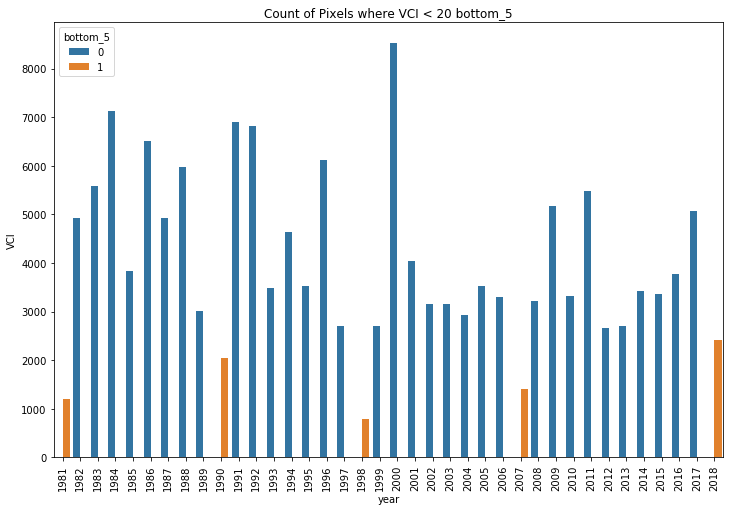

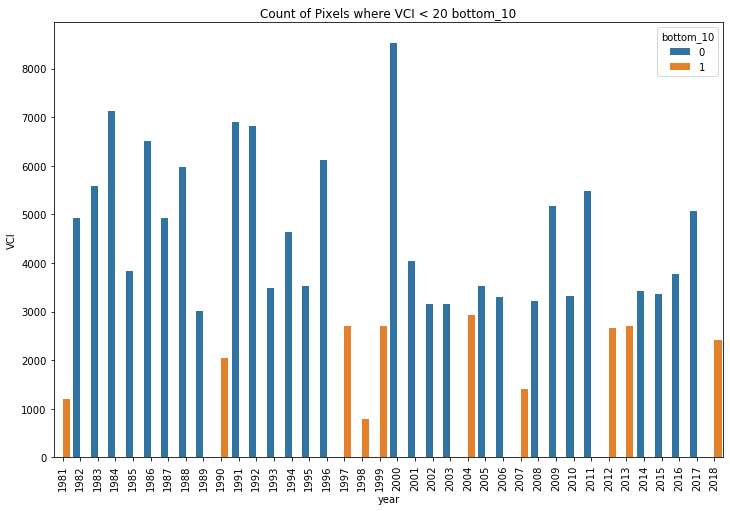

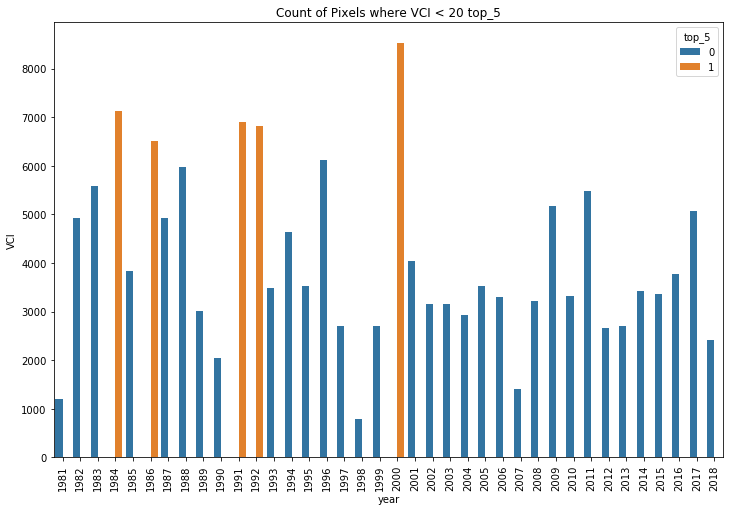

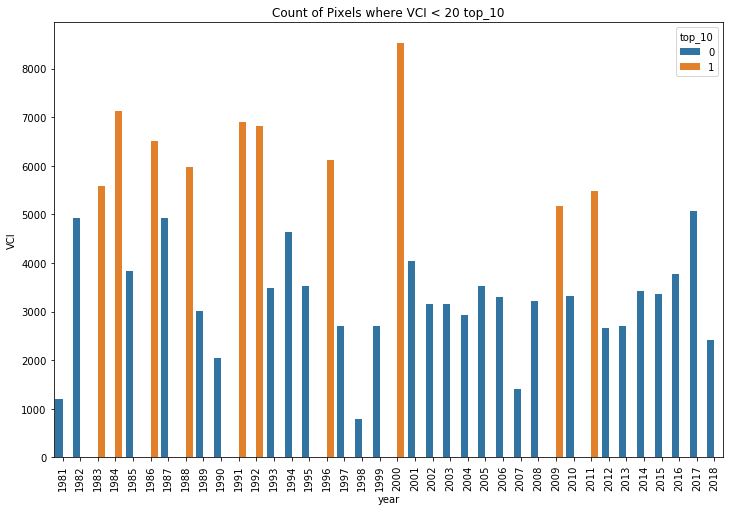

In [66]:
hue = 'bottom_5'

def plot_year_subsets(hue: str):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x='year', y='VCI', data=df, hue=hue)
    plt.xticks(rotation=90);
    ax.set_title(f'Count of Pixels where VCI < 20 {hue}')
    
plot_year_subsets(hue='bottom_5')
plot_year_subsets(hue='bottom_10')
plot_year_subsets(hue='top_5')
plot_year_subsets(hue='top_10')

